# BANK CREDIT SCORE

Prepared by: **Evgenii Murzagildinov**

Project on:
- git https://github.com/tarbsinc/DS-Repository/tree/master/module_4
- kaggle https://www.kaggle.com/tarb212/notebookf5006f8162

# 0. Libraries Import

In [685]:
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
import os
from math import log as log
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import datetime
from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [686]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None 

In [687]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

# 1. Functions

In [688]:
'''function to label the level of eduction'''


def lvl_educ(value):
    if value == 'SCH':
        value = 1
    elif value == 'GRD':
        value = 2
    elif value == 'UGR':
        value = 3
    elif value == 'PGR':
        value = 4
    elif value == 'ACD':
        value = 5
    return value


'''function with core metrics'''


def core_metrics(y_valid, y_pred, y_pred_proba):
    accuracy = round(accuracy_score(y_valid, y_pred), 3)
    precision = round(precision_score(y_valid, y_pred), 3)
    recall = round(recall_score(y_valid, y_pred), 3)
    f1 = round(f1_score(y_valid, y_pred), 3)
    roc_auc = round(roc_auc_score(y_valid, y_pred_proba), 3)
    if precision == 0:
        precision = 'not available (zero division)'
    if recall == 0:
        recall = 'not available (zero division)'
    if f1 == 0:
        f1 = 'not available (zero division)'
    print('accuracy score is', accuracy)
    print('precision score is', precision)
    print('recall score is', recall)
    print('f1 score is', f1)
    print('roc auc score is', roc_auc)


'''function to check whether the day is weekend or not'''


def is_weekend(day):
    if day >= 5:
        return 1
    else:
        return 0


'''make a Binary variable - is the value 0 or not?'''


def is_not_zero(x):
    if x == 0:
        return x
    else:
        return 1


'''number of requests: 0, 1-2, more than 1'''


def how_many_req(x):
    if x == 0:
        return x
    elif 1 <= x <= 2:
        return 1
    else:
        return 2


'''T-test for cat and bin variables'''


def get_stat_dif(column):
    cols = temp_data.loc[:, column].value_counts().index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(temp_data.loc[temp_data.loc[:, column] == comb[0], 'default'],
                     temp_data.loc[temp_data.loc[:, column] == comb[1], 'default']).pvalue \
                <= 0.05/len(combinations_all):
            print('Statistically significant difference is found for the column', column)
            break


'''StandardScaler for a column'''


def scaler_column(df, column):
    scaler = StandardScaler()
    scaler.fit(df[[column]])
    return scaler.transform(df[[column]])

# 2. Data

In [689]:
PATH_to_file = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')

In [690]:
print(df_train.shape)
print(df_test.shape)

(73799, 19)
(36349, 18)


We will consolidate datasets while Preprocessing and Feature engineering. New column will be added to enable future splitting.

In [691]:
df_train['Train'] = 1
df_test['Train'] = 0

data = df_train.append(df_test, sort=False).reset_index(drop=True)

In [692]:
data.sample(3)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
50405       5258  11JAN2014       SCH   M   36   N        N                0   
88463      96119  12APR2014       GRD   F   26   N        N                0   
11582      15261  22JAN2014       SCH   M   39   Y        Y                2   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
50405          0  -1.174180                1             50             2   
88463          1  -2.387268                1             70             2   
11582          0  -1.002824                1             50             1   

       work_address  income  sna  first_time foreign_passport  default  Train  
50405             3   30000    1           3                N      1.0      1  
88463             3   35000    1           3                N      NaN      0  
11582             3  100000    2           4                N      0.0      1

# 3. Profiling
We'll use **Pandas Profiling module** to have a first look at available data.

Based on the report, the following findings can be highlighted:

- Number of variables - 20.
- Number of observations - 110148.
- Missing cells - 36827 or 1.7% (however this includes blank cells in 'default', i.e. target variable, in test dataset).
- There are no duplicate rows.
- Variable types: Numeric	7, Categorical	10, Boolean	3.
- Decline_app_cnt has 91471 (83.0%) zeros.
- Bki_request_cnt has 28908 (26.2%) zeros.
- The tool also warns us that 'Train' and 'default' are highly correlated to each other, but this is just because the majority of Customers have not defaulted (they have 0 in default column) and the majority of them are also in Train dataset (they have 1 in Train column). Hence this warning can be disregarded.
- Education column is the only one (except for 'default', see above) that has missing values, and there are only 478 (0.4%) of them.
- Only 1/3 of Clients have a car and almost half of those have a foreign car.
- Most of Clients (83.4%) do not have 'good work' marker, per Bank's criteria.
- Score_bki seems the only numeric variable that has normal distribution.
- Income level is very different, the range between the lowest and the highest is 999000, with the ratio of 1:1000.
- Only 15% of Customers have a foreign passport (or notified the Bank about it)
- Home address is positively correlated with work address.
- First_time is negatively correlated with sna.
- Income is positively correlated with the region ranking.
- None of variables are highly correlated with the target variable (default)

In [693]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 4. Exploratory Data Analysis
The goal of performing EDA is to develop an understanding of our data. 

## General info: variables, values, observations
A **variable** is a quantity, quality, or property that we measure. Columns in our dataset bear names of our variables. Our initial variables are:

- client_id - Client id
- education - level of education (school, undergraduate, graduate, postgraduate, academic qualification)
- sex - sex 
- age - age
- car - car mark (Y/N)
- car_type - foreign car mark (Y/N)
- decline_app_cnt - number of previously declined applications
- good_work - "good" work marker 
- bki_request_cnt - number of requests to BKI (Credit Buneau Agency)
- home_address - home address category
- work_address - work address category
- income - income level
- foreign_passport - foreign passport mark
- sna - level of affiliation of the Borrower with Clients of the Bank 
- first_time - first time information obtained
- score_bki - BKI (Credit Buneau Agency) score 
- region_rating - region rating/ranking
- app_date - application date
- default - credit default mark


- plus, we have already added a new column "Train", with a marker which will then help us split dataset back into train and test sets.

In [694]:
data.sample(3)

client_id   app_date education sex  age car car_type  decline_app_cnt  \
51180      61979  11MAR2014       UGR   F   28   N        N                1   
33320      63693  13MAR2014       SCH   F   39   Y        Y                0   
52890     109426  30APR2014       GRD   M   53   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
51180          0  -2.038206                1             80             2   
33320          0  -1.902189                1             40             1   
52890          0  -1.938446                2             60             1   

       work_address  income  sna  first_time foreign_passport  default  Train  
51180             3   30000    1           4                Y      0.0      1  
33320             2   25000    1           3                N      0.0      1  
52890             3   27500    1           4                N      0.0      1

In [695]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

A **value** is the state of a variable. The value of a variable may change from measurement to measurement.

We have numeric, categorical, binary values and one column with date (which currently is in string format). We will mark sex as binary variable, though it might be treated as categorical if new option is introduced (e.g. 'non-binary' or 'prefer not to answer').

In [696]:
# 'client_id' is also numeric but is removed from the list as adding no value
num_var = ['age', 'decline_app_cnt',
           'bki_request_cnt', 'score_bki', 'income']
cat_var = ['education', 'region_rating', 'home_address',
           'work_address', 'sna', 'first_time']
bin_var = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
date_var = ['app_date']

An **observation** is a set of measurements made under similar conditions. An observation will contain several values, each associated with a different variable. It can also be referred to as a data point. One row in our dataset is one observation.

Let us check the number of observations in the whole dataset and in train and test subsets:

In [697]:
print(data.shape)
print((data[data['Train'] == 1]).shape)
print((data[data['Train'] == 0]).shape)

(110148, 20)
(73799, 20)
(36349, 20)


## Default Customers: Target Variable
87.3% of Customers do not default on their loans, and only 12.7% of them do.

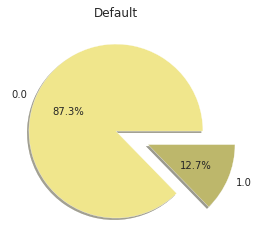

In [698]:
default_data = data['default'].value_counts()
default_labels = list(data['default'].value_counts().index)
colors = ['#F0E68C', '#BDB76B']
plt.pie(default_data, labels=default_labels, autopct='%1.1f%%',
        shadow=True, colors=colors, explode=[0, 0.4])
plt.title('Default')
plt.show()

##  Numeric Variables: Distribution

- Age range is 21-72, its distribution is positively-skewed, with a peak at 30.
- Decline_app_cnt (number of previously declined applications) and bki_request_cnt (number of requests to BKI) are positively-skewed, with their peak at 0.
- Score_bki has near normal distribution.
- Income distribution is positively-skewed: mean income is 41k, while meadian income is 30k; difference between min and max income is huge - 1k vs 1mio.

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'decline_app_cnt'}>],
       [<AxesSubplot:title={'center':'bki_request_cnt'}>,
        <AxesSubplot:title={'center':'score_bki'}>],
       [<AxesSubplot:title={'center':'income'}>, <AxesSubplot:>]],
      dtype=object)

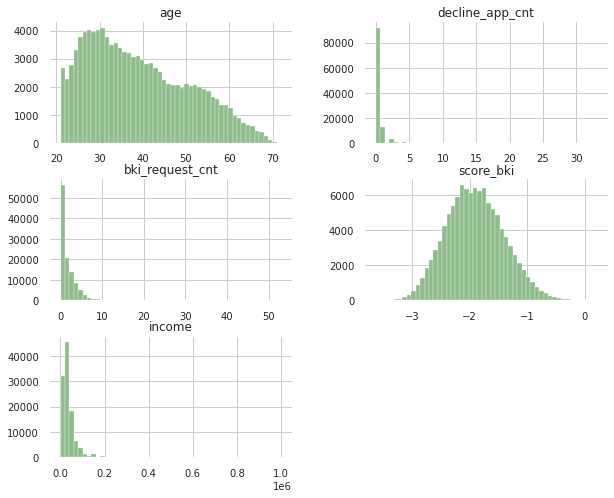

In [699]:
data[num_var].hist(figsize=(10, 8), bins=50, color='#8FBC8B')

In [700]:
data[num_var].describe()

age  decline_app_cnt  bki_request_cnt      score_bki  \
count  110148.000000    110148.000000    110148.000000  110148.000000   
mean       39.249410         0.273205         2.005002      -1.904535   
std        11.518063         0.799099         2.266926       0.499397   
min        21.000000         0.000000         0.000000      -3.624586   
25%        30.000000         0.000000         0.000000      -2.260434   
50%        37.000000         0.000000         1.000000      -1.920823   
75%        48.000000         0.000000         3.000000      -1.567888   
max        72.000000        33.000000        53.000000       0.199773   

               income  
count   110148.000000  
mean     41012.648537  
std      45399.735051  
min       1000.000000  
25%      20000.000000  
50%      30000.000000  
75%      48000.000000  
max    1000000.000000

## Numeric Variables: Defaulted vs not Defaulted
Generaly, per boxplots we can see that there are outliers in numeric varibles.

If dataset is divided into defaulted and not defaulted Clients, we can see that:
- defaulted Clients are generally younger
- defaulted Clients generally have more declined applications
- defaulted Clients generally have more BKI requests
- defaulted Clients generally have higher BKI score
- defaulted Clients generally have lower income

In [701]:
data_def0 = data[data['default'] == 0]  # no defaults
data_def1 = data[data['default'] == 1]  # with defaults

<AxesSubplot:>

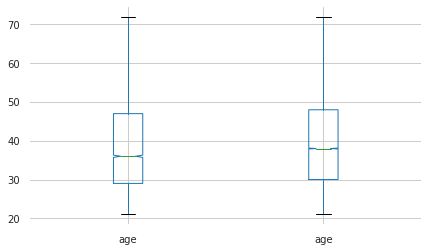

In [702]:
pd.concat([data_def1['age'], data_def0['age']],
          axis=1).boxplot(figsize=(7, 4), notch=True)

<AxesSubplot:>

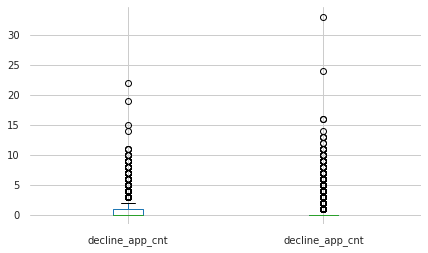

In [703]:
pd.concat([data_def1['decline_app_cnt'], data_def0['decline_app_cnt']],
          axis=1).boxplot(figsize=(7, 4))

<AxesSubplot:>

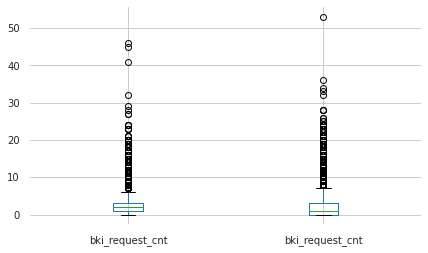

In [704]:
pd.concat([data_def1['bki_request_cnt'], data_def0['bki_request_cnt']],
          axis=1).boxplot(figsize=(7, 4))

<AxesSubplot:>

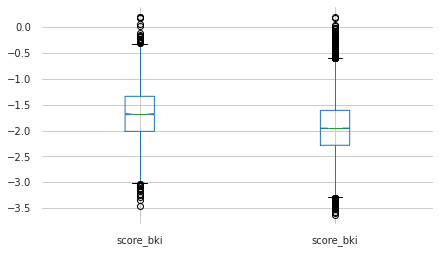

In [705]:
pd.concat([data_def1['score_bki'], data_def0['score_bki']],
          axis=1).boxplot(figsize=(7, 4), notch=True)

<AxesSubplot:>

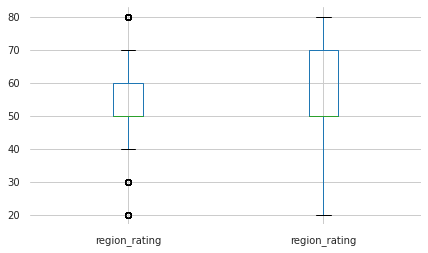

In [706]:
pd.concat([data_def1['region_rating'], data_def0['region_rating']],
          axis=1).boxplot(figsize=(7, 4))

<AxesSubplot:>

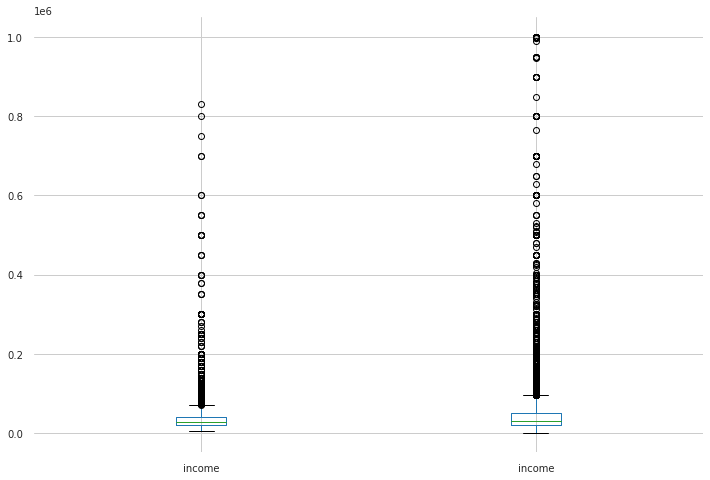

In [707]:
pd.concat([data_def1['income'], data_def0['income']],
          axis=1).boxplot(figsize=(12, 8))

Though **region rating** is **categorical variable**, we can also check via boxplots how it possibly affects default. Per chart below, **defaulted Clients generally are from regions with lower rankings**:

<AxesSubplot:>

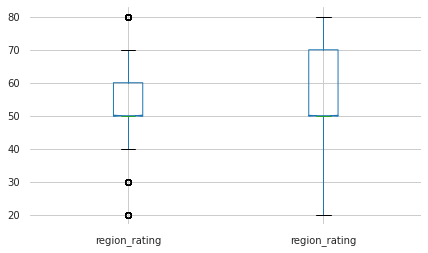

In [708]:
pd.concat([data_def1['region_rating'], data_def0['region_rating']],
          axis=1).boxplot(figsize=(7, 4), notch=True)

## Numeric Variables (plus region rating): Correlation
We will also add region rating to correlation analysis, since it is **ordered categorical variable**. 

The higher region ranking the higher is income, which is expected. These two variables have the highest correlation coefficient, 0.21. After them we have correlation of 0.19 between BKI score and number of previously declined applications. Please note that correlation, especially low or moderate, does not necessarily imply there is any form of association.

Generally, we can admit that **correlation (i.e. Pearson correlation coefficient) is low (below 0.29) for all numeric variables**, which is good, meaning variables are independent and we do not need to apply regularization to avoid overfitting, like adding penalties, etc. 

In [709]:
# let's see correlation coefficients
data[['age', 'decline_app_cnt', 'bki_request_cnt',
      'score_bki', 'income', 'region_rating']].corr()

age  decline_app_cnt  bki_request_cnt  score_bki  \
age              1.000000        -0.111454         0.046975  -0.104682   
decline_app_cnt -0.111454         1.000000         0.159927   0.187869   
bki_request_cnt  0.046975         0.159927         1.000000   0.157451   
score_bki       -0.104682         0.187869         0.157451   1.000000   
income          -0.018664        -0.022241         0.080475  -0.011721   
region_rating   -0.089147        -0.038254         0.006780   0.007132   

                   income  region_rating  
age             -0.018664      -0.089147  
decline_app_cnt -0.022241      -0.038254  
bki_request_cnt  0.080475       0.006780  
score_bki       -0.011721       0.007132  
income           1.000000       0.207494  
region_rating    0.207494       1.000000

<AxesSubplot:>

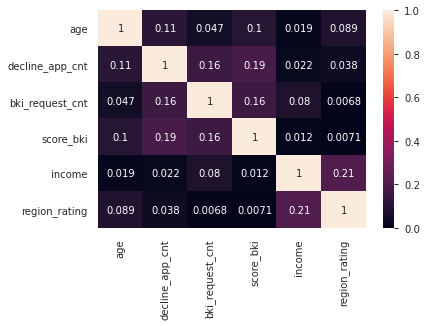

In [710]:
# let's visualize the correlation with modulus (absolute values),
# since we are interested more in the level of dependency irrespective of the sign.
sns.heatmap(data[['age', 'decline_app_cnt', 'bki_request_cnt', 'score_bki',
                  'income', 'region_rating']].corr().abs(), annot=True, vmin=0, vmax=1)

## EDA observations:
1. There are 73 799 rows in train set, 36 349 rows in test set, which gives us **110 148 observations** in total. 
2. There are **20 variables**:

    - **6 numeric** variables, one of them is a unique client identifier with no value for analysis ('client_id', 'age', 'decline_app_cnt', 'bki_request_cnt', 'score_bki', 'income')
    - **6 categorical** variables ('education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time'). One of them, 'region_rating', is apparently ordered variable, hence sometimes it is analyzed together with numeric ones.
    - **5 binary** variables ('sex', 'car', 'car_type', 'good_work', 'foreign_passport')
    - **1 date** variable ('app_date')
    - **1 target** variable ('default') and **1 temporary** column for differentiating train and test datasets ('Train'), both are binary variables.
    
    
3. **14 columns have float and integer values, 5 columns have string values** - most of the latter need to be transformed into integer values (by labelling categorical variables) and one (application date) - to datetime.
4. Only **13 out of 100** Customers default on their loans.
5. **Distribution for all numeric variables, with exception of BKI score, is skewed.** BKI score has near normal distribution. Region rating distribution is about normal, however there are 2 peaks. Others are right-skewed (have positive skewness), hence log transformation might be useful.
6. **Defaulted Clients** are generally younger, have more declined applications and more BKI requests, have higher BKI score, are from regions with lower rankings, and, apparently, have lower income.
7. **Pearson correlation coefficient** for numeric variables is low (0.21 and lower) which is good, meaning variables are independent. Risk of overfitting is low, hence we do not need to apply regularization at this point.

# 5. Dealing with Missing Values

There are missing values in Default column, which is target variable, - all of them are in test dataset (36349 rows). Since we will split dataset back into train and test sets then after prepping, this should be disregarded.

Apart from that, within independent variables, missing values are found only in the column with education level. There are only 478 missing values which is **0.4%** of the whole dataset, hence we will keep education level column and will try to fill in NAN cells.

In [711]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

In [712]:
len(data[data['education'].isnull()])/len(data)

0.004339615789664814

Since missing values in education column are only 0.4% and school education is the most frequent value (53% of non-NAN values), let us fill in NAN cells with SCH (mode).

In [713]:
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [714]:
# ratio of SCH to all non-NAN values
data['education'].value_counts()[0]/data['education'].value_counts().sum()

0.528841068660527

In [715]:
# using mode to fill in NAN cells
data['education'].fillna(list(data['education'].mode())[0], inplace=True)

In [716]:
# let us check how ratio changed: the difference is less than 1%
data['education'].value_counts()[0]/data['education'].value_counts().sum()

0.5308857173984094

# 6. Duplicate Records
There are no duplicate records in the dataset, which is obviously good. This has already been shown by Pandas Profiling tool.

In [717]:
data.duplicated().sum()

0

# 7. Dealing with Outliers
**Outliers** are observations that are unusual; data points that don’t seem to fit the pattern. Sometimes outliers are data entry errors - other times outliers suggest important new knowledge. Outliers, being **the most extreme observations**, may include the sample maximum or sample minimum, or both, depending on whether they are extremely high or low. 

However, the sample maximum and minimum are not always outliers. Apart from different algorithms, we should use **our own judgement** to decide whether extreme observations are outliers and whether they should be removed, amended or left as-is.

## Outliers in Numeric Variables

### I. Age

As we have already seen when checking distribution, age is in range 21 to 72, which is OK, this is normal age for a person to be a bank's client and become a borrower. We can conclude that **there are no outliers in age**. To balance the data, we can use log transformation (see details in transformation section).

<AxesSubplot:>

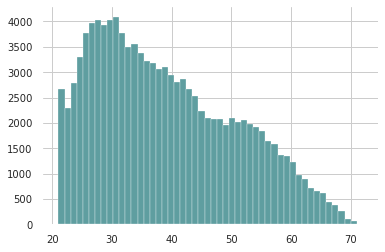

In [718]:
data['age'].hist(bins=50, color='#5F9EA0')

<AxesSubplot:>

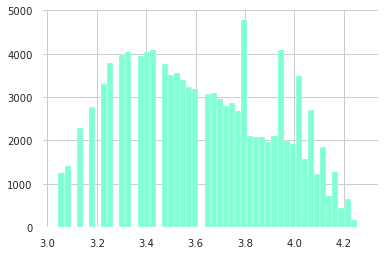

In [719]:
np.log(data['age']).hist(bins=50, color='#7FFFD4')

### II. Decline_app_cnt

This is the number of previously declined applications. **Most of the Customers have had no declines (83%)**, however within other 17% there are Customers with **up to 33 declines**. 

**We will not treat such numbers as outliers** (it is possible for a Customer to have numerous declines), however further we can devide Customers into bigger groups, for example, (1) no declines, (2) one or more declines. Since the difference is still big (4:1), further transformation might be required.

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64


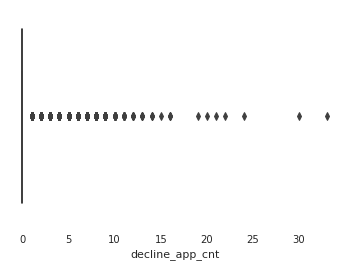

In [720]:
sns.boxplot(data=data, x=data['decline_app_cnt'])
print(data['decline_app_cnt'].describe())

In [721]:
# ratio - Customers with zero declines to all Customers
data['decline_app_cnt'].value_counts()[0]/len(data)

0.8304372299088499

### III. Bki_request_cnt
This is the number of requests to BKI (Credit Buneau Agency). This one is quite similar to the previous variable. Though it is not the majority, however **big part of Customers (26%) has zero requests**. But the maximum is **53 requests**. 

Again, this is not something unusual, so **we will not treat those as outliers**, however transformation (e.g. log transformation) may be required. 

count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64


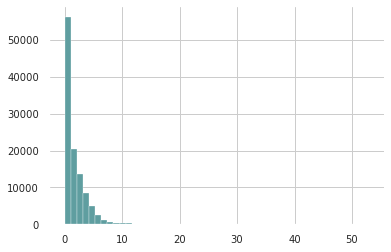

In [722]:
data['bki_request_cnt'].hist(bins=50, color='#5F9EA0')
print(data['bki_request_cnt'].describe())

<AxesSubplot:>

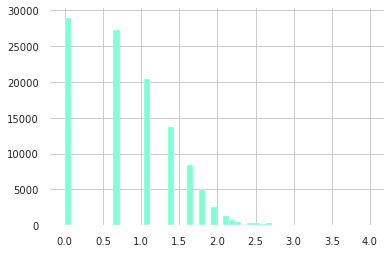

In [723]:
# if log transformation applied, distribution becomes better
np.log(data['bki_request_cnt']+1).hist(bins=50, color='#7FFFD4')

In [724]:
# ratio - Customers with zero declines to all Customers
data['bki_request_cnt'].value_counts()[0]/len(data)

0.2624468896393943

Almost the same number of Customers have 1 and 2 BKI requests:

In [725]:
data['bki_request_cnt'].value_counts()

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
24       12
23       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
40        2
33        2
36        1
34        1
41        1
45        1
46        1
47        1
53        1
Name: bki_request_cnt, dtype: int64

### IV. Score_bki
This is BKI (Credit Buneau Agency) score. It has normal distribution.
**Most of the Clients have a score of below zero**, and only 12 of them have a positive score. This seems unusual, and I suggest updating this column by replacing score with its **absolute value**. It will be more understandable (then defaulted Clients will have lower BKI scores), and outliers (we will treat them as such) with different sign will be corrected. 

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64
Number of rows with positive score is 12


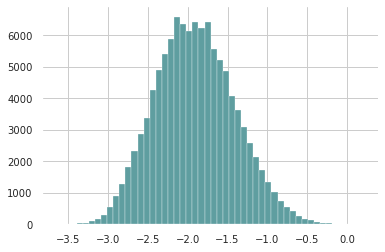

In [726]:
data['score_bki'].hist(bins=50, color='#5F9EA0')
print(data['score_bki'].describe())
print('Number of rows with positive score is',
      len(data[data['score_bki'] > 0]))

In [727]:
data['score_bki'] = data['score_bki'].abs()  # replacing with absolute values

Now let us check **boxplot** and **IQR** for the variable. Per both of them there are outliers, but **99.5% of observations lie within the normal range**. Since there are no limitations for a score to be below 0.53 or above 3.3, we will not make any corrections to these 0.5%.

<AxesSubplot:xlabel='score_bki'>

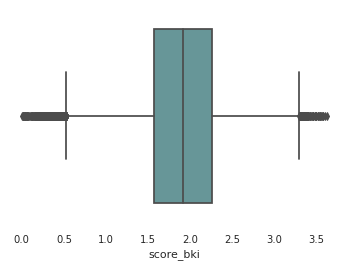

In [728]:
sns.boxplot(data=data, x=data['score_bki'], color='#5F9EA0')

In [729]:
# Interquartile range (IQR)
IQR = round((data['score_bki'].quantile(0.75) -
             data['score_bki'].quantile(0.25)), 3)
perc25 = round(data['score_bki'].quantile(0.25), 3)
perc75 = round(data['score_bki'].quantile(0.75), 3)
left = round((perc25 - 1.5*IQR), 2)
right = round((perc75 + 1.5*IQR), 2)
print('25th percentile: {},'.format(perc25), '75th percentile: {},'.format(
    perc75), "IQR: {}, ".format(IQR), "Non-outlier range: [{}, {}].".format(left, right))

25th percentile: 1.568, 75th percentile: 2.26, IQR: 0.693,  Non-outlier range: [0.53, 3.3].


In [730]:
# Fraction of observations within the non-outlier range
len(data.loc[data['score_bki'].between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)])/len(data)

0.9953063151396303

### V. Income
The level of income is very diverse. However instead of removing outliers, it is recommended to apply **log transformation**, which will deal with both the outliers and skewness.

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64


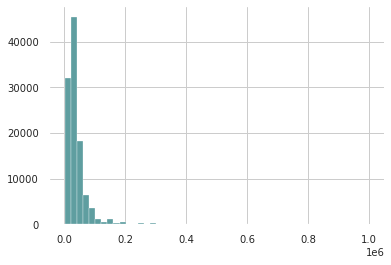

In [731]:
data['income'].hist(bins=50, color='#5F9EA0')
print(data['income'].describe())

In [732]:
# Interquartile range (IQR)
IQR = round((data['income'].quantile(0.75) -
             data['income'].quantile(0.25)), 3)
perc25 = round(data['income'].quantile(0.25), 3)
perc75 = round(data['income'].quantile(0.75), 3)
left = round((perc25 - 1.5*IQR), 2)
right = round((perc75 + 1.5*IQR), 2)
print('25th percentile: {},'.format(perc25), '75th percentile: {},'.format(
    perc75), "IQR: {}, ".format(IQR), "Non-outlier range: [{}, {}].".format(left, right))

25th percentile: 20000.0, 75th percentile: 48000.0, IQR: 28000.0,  Non-outlier range: [-22000.0, 90000.0].


In [733]:
# Fraction of observations within the non-outlier range
len(data.loc[data['income'].between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)])/len(data)

0.9364491411555362

<AxesSubplot:>

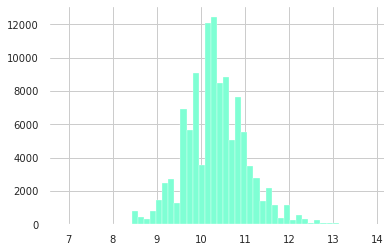

In [734]:
# Distribution becomes way better (normal) after log transformation
np.log(data['income']).hist(bins=50, color='#7FFFD4')

# 8. Odd values in Categorical and Binary variables
To make sure there are no obvious errors in columns with Categorical and Binary variables, we will check unique values in these columns. For example, if categorical variable can be 1, 2 or 3, a value of 40 would be odd and most probably an error. Or any third value would jeopardize calculations for binary variables.

In [735]:
# let's check unique values for categorical variables first:
for i in cat_var:
    print(data[i].unique())

['SCH' 'GRD' 'UGR' 'PGR' 'ACD']
[50 80 60 40 70 20 30]
[1 2 3]
[2 3 1]
[4 1 2 3]
[1 4 3 2]


In [736]:
# now binary:
for i in bin_var:
    print(data[i].unique())

['M' 'F']
['Y' 'N']
['Y' 'N']
[0 1]
['N' 'Y']


There seems to be **no odd values** for Categorical and Binary variables.

# 9. Labelling Binary variables
We will ise LabelEncoder for labelling Binary variables.

In [737]:
label_encoder = LabelEncoder()

for column in bin_var:
    data[column] = label_encoder.fit_transform(data[column])

In [738]:
# let's check the results
data.sample(5)

client_id   app_date education  sex  age  car  car_type  \
90843      47349  24FEB2014       GRD    0   30    0         0   
39153      15752  23JAN2014       SCH    1   28    0         0   
19218       8277  15JAN2014       SCH    0   46    1         1   
59446      16364  23JAN2014       UGR    1   28    1         1   
30933      68750  17MAR2014       GRD    1   42    0         0   

       decline_app_cnt  good_work  score_bki  bki_request_cnt  region_rating  \
90843                0          0   2.228633                1             60   
39153                1          0   1.872447                2             50   
19218                0          0   2.353754                0             40   
59446                0          0   1.668504                0             70   
30933                0          1   2.448880                2             30   

       home_address  work_address  income  sna  first_time  foreign_passport  \
90843             1             1   30000    2           3                 0   
39153             2             3   31000    1           4                 0   
19218             2             3   70000    1           3                 0   
59446             1             3  130000    1           4                 1   
30933             1             1   31000    1           2                 0   

       default  Train  
90843      NaN      0  
39153      1.0      1  
19218      0.0      1  
59446      0.0      1  
30933      0.0      1

# 10. Labelling Categorical Variables
For **education** we will use use a function we wrote, since we need to keep the order: 1 - school, 2 - undergraduate, 3 - graduate, 4 - postgraduate, 5 - academic qualification.

In [739]:
data['education'] = data['education'].apply(lambda x: lvl_educ(x))

Other categorical variables are already labelled with numbers.

In [740]:
data.sample(5)

client_id   app_date  education  sex  age  car  car_type  \
58972      77125  25MAR2014          2    0   41    0         0   
16891      91893  08APR2014          3    0   40    0         0   
98313      20776  28JAN2014          2    0   28    1         0   
25926      78675  26MAR2014          1    0   43    0         0   
77899      24800  31JAN2014          1    1   33    1         0   

       decline_app_cnt  good_work  score_bki  bki_request_cnt  region_rating  \
58972                0          0   1.356212                5             70   
16891                0          1   2.382346                2             50   
98313                0          1   1.509819                1             80   
25926                0          1   1.738491                1             50   
77899                1          0   1.072387                0             50   

       home_address  work_address  income  sna  first_time  foreign_passport  \
58972             2             3   33000    2           1                 0   
16891             1             2   12000    1           4                 0   
98313             2             3   35000    4           3                 0   
25926             1             3    8900    1           3                 0   
77899             1             3   40000    2           2                 0   

       default  Train  
58972      0.0      1  
16891      0.0      1  
98313      NaN      0  
25926      0.0      1  
77899      NaN      0

# 11. Naïve Model
We have cleaned and prepped the initial data. Before performing further transformations, let us build a naïve model. This will help us understand whether our further upgrades and transformations are indeed improving the model.
We will also drop client id, since it bears no value, and app_date, since it is a string value.

In [741]:
train_data = data[data['Train'] == 1].drop(['client_id', 'app_date'], axis=1)
test_data = data[data['Train'] == 0].drop(['client_id', 'app_date'], axis=1)

y = train_data['default'].values
X = train_data.drop(['default'], axis=1)

# we will use train_test_split for validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

logreg = LogisticRegression(random_state=RANDOM_SEED)

logreg.fit(X_train, y_train)

y_pred_proba = logreg.predict_proba(X_valid)[:, 1]
y_pred = logreg.predict(X_valid)

In [742]:
core_metrics(y_valid, y_pred, y_pred_proba)

accuracy score is 0.876
precision score is not available (zero division)
recall score is not available (zero division)
f1 score is not available (zero division)
roc auc score is 0.584


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


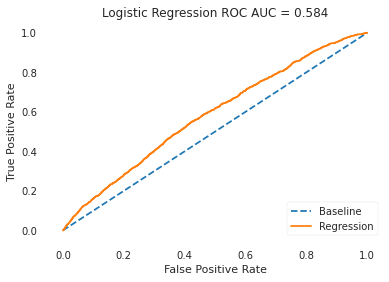

In [743]:
fpr, tpr, threshold = roc_curve(y_valid, y_pred_proba)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Even naïve model is a bit better than simple guessing. Further we will try to improve the model, and the initial values of metrics will help us prove that our improvements are plausible.

**Now ROC AUC score is 0.584.**

# 12. Feature Engineering
## Datetime
We will update app_date column to datetime format to enable further calculations and feature engineering.

In [744]:
data['app_date'] = pd.to_datetime(data['app_date'])

We will new add a couple of new features and then check if they are of any value.

In [745]:
# number of days from current date - new Numeric Variable
today = pd.to_datetime(date.today())
data['days_from_today'] = (today - data['app_date']).dt.days
num_var.append('days_from_today')

In [746]:
# day of week - new Categorical Variable
data['days_of_week'] = data['app_date'].dt.dayofweek
cat_var.append('days_of_week')

In [747]:
# weekend marker - new Binary variable
data['is_weekend'] = data['days_of_week'].apply(lambda x: is_weekend(x))
bin_var.append('is_weekend')

Since there are only 4 months in the dataset (Jan-Apr) we will not add any new features with months (we do not have data for the rest 8 months)

In [748]:
data['app_date'].dt.month.unique()

array([2, 3, 1, 4])

## New decline_app_cnt - Binary
We will add new feature, a binary decline_app_cnt - no declines (0), one or more declines (1), since as it has been shown above the majority of Clients do not have declines. It might be more useful to have this as binary and not a numeric variable.

In [749]:
data['was_declined'] = data['decline_app_cnt'].apply(lambda x: is_not_zero(x))
bin_var.append('was_declined')

## New bki_request_cnt
We will add new feature, not categorical, not binary, with bki_request_cnt: 0 - no requests, 1 - few requests (1-2), 2 - many requests (more than 2).

In [750]:
data['cat_bki_request_cnt'] = data['bki_request_cnt'].apply(lambda x: how_many_req(x))
cat_var.append('cat_bki_request_cnt')

## One-Hot Encoding for Categorical Variables
We have already applied LabelEncoder to Binary variables and sex variables, plus labelled education level with a new function. Now we will get dummies for categorical variables (i.e. apply One-Hot Encoding) other than sex (which currently has only 2 options).

In [751]:
data = pd.get_dummies(data, columns=cat_var)

In [752]:
data.sample(5)

client_id   app_date  sex  age  car  car_type  decline_app_cnt  \
64916       55712 2014-03-04    1   30    0         0                0   
80582        4506 2014-01-10    1   36    0         0                0   
3611        76651 2014-03-24    0   33    0         0                0   
33260       15351 2014-01-22    1   54    0         0                0   
103103       5613 2014-01-12    1   26    0         0                0   

        good_work  score_bki  bki_request_cnt  income  foreign_passport  \
64916           0   2.363027                2   30000                 0   
80582           0   1.152461                1   30000                 0   
3611            1   1.789777                2   35000                 0   
33260           0   2.194608                5   15000                 0   
103103          0   2.074185                3   65000                 0   

        default  Train  days_from_today  is_weekend  was_declined  \
64916       0.0      1             2577           0             0   
80582       NaN      0             2630           0             0   
3611        0.0      1             2557           0             0   
33260       0.0      1             2618           0             0   
103103      NaN      0             2628           1             0   

        education_1  education_2  education_3  education_4  education_5  \
64916             1            0            0            0            0   
80582             1            0            0            0            0   
3611              0            0            1            0            0   
33260             1            0            0            0            0   
103103            0            1            0            0            0   

        region_rating_20  region_rating_30  region_rating_40  ...  \
64916                  0                 0                 0  ...   
80582                  0                 0                 0  ...   
3611                   0                 0                 0  ...   
33260                  0                 0                 0  ...   
103103                 0                 0                 0  ...   

        region_rating_80  home_address_1  home_address_2  home_address_3  \
64916                  0               1               0               0   
80582                  1               0               1               0   
3611                   0               0               1               0   
33260                  0               0               1               0   
103103                 1               0               1               0   

        work_address_1  work_address_2  work_address_3  sna_1  sna_2  sna_3  \
64916                0               1               0      0      0      0   
80582                0               0               1      1      0      0   
3611                 0               0               1      1      0      0   
33260                0               0               1      0      0      0   
103103               0               0               1      1      0      0   

        sna_4  first_time_1  first_time_2  first_time_3  first_time_4  \
64916       1             1             0             0             0   
80582       0             1             0             0             0   
3611        0             0             0             1             0   
33260       1             1             0             0             0   
103103      0             0             0             0             1   

        days_of_week_0  days_of_week_1  days_of_week_2  days_of_week_3  \
64916                0               1               0               0   
80582                0               0               0               0   
3611                 1               0               0               0   
33260                0               0               1               0   
103103               0               0               0               0   

        days_of

## Polynomial (Cross) Features
Polynomial features create interactions among features. They help to capture relationships among independent variables.
We can create polynomial/cross features manually by simply adding, multiplying, or dividing features with each other. Here we will use the Polynomial Feature module.

We will create polynomial features from the numeric variables.

In [753]:
poly = PolynomialFeatures()
crossed_feats = poly.fit_transform(data[num_var].values)

crossed_feats = pd.DataFrame(crossed_feats)
data = pd.concat([data, crossed_feats], axis=1)

In [754]:
data.sample(5)

client_id   app_date  sex  age  car  car_type  decline_app_cnt  \
100830      95443 2014-04-11    1   47    0         0                1   
33723       85323 2014-04-02    0   39    0         0                0   
9693       108436 2014-04-28    1   56    0         0                0   
48471       91719 2014-04-08    1   55    1         1                0   
68783       76362 2014-03-24    0   28    0         0                0   

        good_work  score_bki  bki_request_cnt  income  foreign_passport  \
100830          0   2.672553                3    6100                 0   
33723           1   1.860977                4   60000                 0   
9693            0   2.262065                1   47000                 0   
48471           0   2.716265                0   30000                 0   
68783           1   1.972617                1   30000                 0   

        default  Train  days_from_today  is_weekend  was_declined  \
100830      NaN      0             2539           0             1   
33723       1.0      1             2548           0             0   
9693        0.0      1             2522           0             0   
48471       0.0      1             2542           0             0   
68783       1.0      1             2557           0             0   

        education_1  education_2  education_3  education_4  education_5  \
100830            1            0            0            0            0   
33723             1            0            0            0            0   
9693              0            1            0            0            0   
48471             1            0            0            0            0   
68783             1            0            0            0            0   

        region_rating_20  region_rating_30  region_rating_40  ...    3  \
100830                 0                 0                 0  ...  3.0   
33723                  0                 0                 0  ...  4.0   
9693                   0                 0                 0  ...  1.0   
48471                  0                 0                 0  ...  0.0   
68783                  0                 0                 0  ...  1.0   

               4        5       6       7     8      9          10         11  \
100830  2.672553   6100.0  2539.0  2209.0  47.0  141.0  125.609993   286700.0   
33723   1.860977  60000.0  2548.0  1521.0   0.0  156.0   72.578090  2340000.0   
9693    2.262065  47000.0  2522.0  3136.0   0.0   56.0  126.675624  2632000.0   
48471   2.716265  30000.0  2542.0  3025.0   0.0    0.0  149.394584  1650000.0   
68783   1.972617  30000.0  2557.0   784.0   0.0   28.0   55.233289   840000.0   

              12   13   14        15      16      17    18        19  \
100830  119333.0  1.0  3.0  2.672553  6100.0  2539.0   9.0  8.017659   
33723    99372.0  0.0  0.0  0.000000     0.0     0.0  16.0  7.443907   
9693    141232.0  0.0  0.0  0.000000     0.0     0.0   1.0  2.262065   
48471   139810.0  0.0  0.0  0.000000     0.0     0.0   0.0  0.000000   
68783    71596.0  0.0  0.0  0.000000     0.0     0.0   1.0  1.972617   

              20       21        22             23           24            25  \
100830   18300.0   7617.0  7.142540   16302.573605  6785.612194  3.721000e+07   
33723   240000.0  10192.0  3.463234  111658.599600  4741.768530  3.600000e+09   
9693     47000.0   2522.0  5.116937  106317.041370  5704.927199  2.209000e+09   
48471        0.0      0.0  7.378096   81487.955100  6904.746062  9.000000e+08   
68783    30000.0   2557.0  3.891220   59178.523800  5043.982845  9.000000e+08   

                 26         27  
100830   15487900.0  6446521.0  
33723   152880000.0  6492304.0  
9693    118534000.0  6360484.0  
48471    76260000.0  6461764.0  
68783    76710000.0  6538249.0  

[5 rows x 81 columns]

In [755]:
# removing column 0 since it is a column with ones
data = data.drop(0, axis=1)

# we'll create a separate category for these variables (removing column 0 since it is a column with ones):
poly_var = []
for i in range(1, 28):
    poly_var.append(i)

# 13. Data Transformation
## Log transformation
We will apply log transformation to numeric variables which were found to have skewness in their distribution.

In [756]:
data['age'] = np.log(data['age'])
# we'll add 1 where values can be = 0
data['decline_app_cnt'] = np.log(data['decline_app_cnt']+1)
data['bki_request_cnt'] = np.log(data['bki_request_cnt']+1)
data['income'] = np.log(data['income'])

# 14. Significant Variables

## Continuous Variables: Analysis of Variance (ANOVA) 
ANOVA uses F-tests to statistically assess the equality of means when you have three or more groups, to determine whether the mean differences are statistically significant.

In [757]:
# continuous variables are numeric variables and those synthesized
# from the latter with Polynomial Feature module
num_poly_var = num_var+poly_var

In [758]:
temp_data = data[data['Train']==1]
imp_num = pd.Series(f_classif(temp_data[num_poly_var], temp_data['default'])[0], index = num_poly_var)
imp_num.sort_values(ascending=False)

score_bki          2340.430385
4                  2340.430385
24                 2298.803661
22                 2120.791057
10                 1209.633784
decline_app_cnt    1152.937317
17                  970.027977
2                   966.206975
8                   879.859393
15                  637.747763
21                  458.492738
bki_request_cnt     457.591760
3                   454.555786
14                  442.729207
23                  378.038307
9                   339.657261
16                  230.064658
income              214.786326
18                  210.909170
13                  168.132187
11                  117.204312
5                   116.798014
26                  114.597331
days_from_today     114.576824
6                   114.576824
27                  114.142011
19                   54.487037
age                  50.440286
1                    46.166168
12                   40.305020
7                    39.585584
20                   28.998952
25      

Let us assume that 1/3 of continuous variables at the bottom of the chart are insignificant and take 2/3 of the top ones.

In [759]:
signf_num_var = list(imp_num.sort_values(
    ascending=False).keys()[:int(len(imp_num)*2/3)])

## Categorical and Binary Variables: Mutual Information and T-test
The Mutual Information is a measure of the similarity between two labels of the same data.

Since quite a lot of new variables were added let's take all columns and remove numeric and polynomial features, and also client_id, app_date, default (target), Train. We'll get an up-to-date list of Categorical and Binary Variables.

In [760]:
bin_cat_var = list(data.columns)
for x in num_poly_var:
    bin_cat_var.remove(x)
    
# and remove a few columns
bin_cat_var.remove('client_id')
bin_cat_var.remove('app_date')
bin_cat_var.remove('default')
bin_cat_var.remove('Train')

<AxesSubplot:>

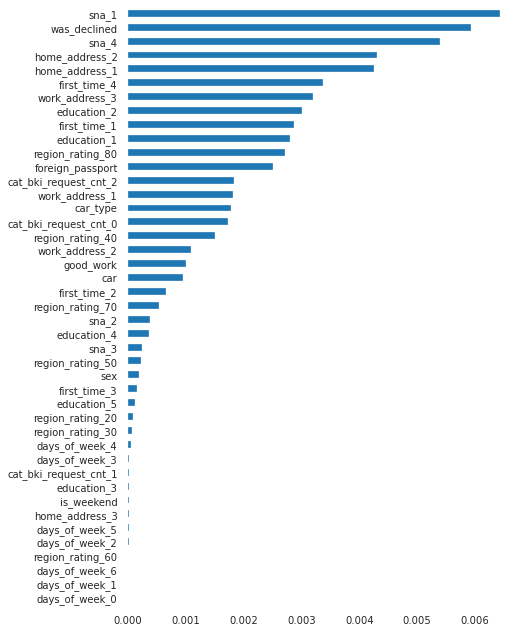

In [761]:
# Mutual Information
temp_data = data[data['Train']==1]
imp_cat = pd.Series(mutual_info_classif(temp_data[bin_cat_var], temp_data['default'],
                                     discrete_features =True), index = bin_cat_var)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh',figsize=(7,11))

So we can see that our exercises with dates have had little value. However no result is also a result, as we know. Let's once again consider dropping the lowest 1/3. However let's first calculate the T-test for the means of combinations of two independent samples of scores.

In [762]:
# 2/3 of the sorted list
list(imp_cat.sort_values(ascending=False).keys()[:int(len(imp_cat)*2/3)])

['sna_1',
 'was_declined',
 'sna_4',
 'home_address_2',
 'home_address_1',
 'first_time_4',
 'work_address_3',
 'education_2',
 'first_time_1',
 'education_1',
 'region_rating_80',
 'foreign_passport',
 'cat_bki_request_cnt_2',
 'work_address_1',
 'car_type',
 'cat_bki_request_cnt_0',
 'region_rating_40',
 'work_address_2',
 'good_work',
 'car',
 'first_time_2',
 'region_rating_70',
 'sna_2',
 'education_4',
 'sna_3',
 'region_rating_50',
 'sex',
 'first_time_3']

In [763]:
# full sorted list to be used for T-test
sorted_list = (list(imp_cat.sort_values(ascending=False).keys()))

# t-test function with Bonferroni correction (see Functions section at the top):
for col in sorted_list:
    get_stat_dif(col)

Statistically significant difference is found for the column sna_1
Statistically significant difference is found for the column was_declined
Statistically significant difference is found for the column sna_4
Statistically significant difference is found for the column home_address_2
Statistically significant difference is found for the column home_address_1
Statistically significant difference is found for the column first_time_4
Statistically significant difference is found for the column work_address_3
Statistically significant difference is found for the column education_2
Statistically significant difference is found for the column first_time_1
Statistically significant difference is found for the column education_1
Statistically significant difference is found for the column region_rating_80
Statistically significant difference is found for the column foreign_passport
Statistically significant difference is found for the column cat_bki_request_cnt_2
Statistically significant diffe

T-test basically confirms our previous findings, it has just more variables marked as significant.

In [764]:
signf_cb_var = sorted_list[:32]

#### Consolidated list of significant features:

In [765]:
signf_var = signf_num_var + signf_cb_var

# 15. Preparing Data for ML
Before prepping the data further, let's check once again interim results.

In [766]:
signf_var_for_model = ['client_id'] + signf_var + ['Train'] + ['default']
data = data[signf_var_for_model]

In [767]:
train_data = data[data['Train'] == 1].drop(['Train', 'client_id'], axis=1)
test_data = data[data['Train'] == 0].drop(['Train', 'client_id'], axis=1)

y = train_data['default'].values
X = train_data.drop(['default'], axis=1)

# train_test_split for validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

logreg = LogisticRegression(random_state=RANDOM_SEED,max_iter=1000)

logreg.fit(X_train, y_train)

y_pred_proba = logreg.predict_proba(X_valid)[:, 1]
y_pred = logreg.predict(X_valid)

core_metrics(y_valid, y_pred, y_pred_proba)

accuracy score is 0.876
precision score is 0.465
recall score is 0.011
f1 score is 0.021
roc auc score is 0.669


**ROC AUC has become a bit better - 0.669**

## Standartization
To avoid leaks, we'll divide data before standartization.

In [768]:
train_data = data[data['Train'] == 1]
test_data = data[data['Train'] == 0]

for column in signf_num_var:
    train_data[column] = scaler_column(train_data, column)

for column in signf_num_var:
    test_data[column] = scaler_column(test_data, column)

data = train_data.append(test_data, sort=False).reset_index(drop=True)

# 16. Check whether Data is imbalanced
The ratio is less than 10:1, so we will consider the data does not require over/undersampling.

In [769]:
classes = data['default'].value_counts(ascending=True)
print('ratio is',classes[0]/classes[1],'(less than 10:1) hence balancing is not required')

ratio is 6.874413145539906 (less than 10:1) hence balancing is not required


# 17. Final Model
It's time to build the final Model.

In [783]:
train_data = data[data['Train'] == 1].drop(['Train', 'client_id'], axis=1)
test_data = data[data['Train'] == 0].drop(['Train', 'client_id'], axis=1)

y = train_data['default'].values
X = train_data.drop(['default'], axis=1)

# train_test_split for validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

logreg = LogisticRegression(random_state=RANDOM_SEED,max_iter=1000)

logreg.fit(X_train, y_train)

y_pred_proba = logreg.predict_proba(X_valid)[:, 1]
y_pred = logreg.predict(X_valid)

In [784]:
core_metrics(y_valid, y_pred, y_pred_proba)

accuracy score is 0.875
precision score is 0.393
recall score is 0.019
f1 score is 0.037
roc auc score is 0.744


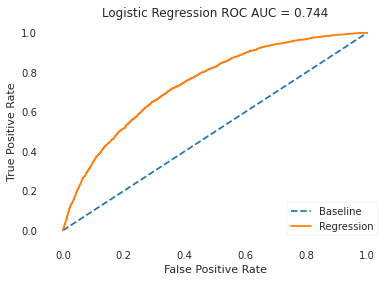

In [772]:
fpr, tpr, threshold = roc_curve(y_valid, y_pred_proba)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

**ROC AUC has become a few percent points higher - 0.744.**

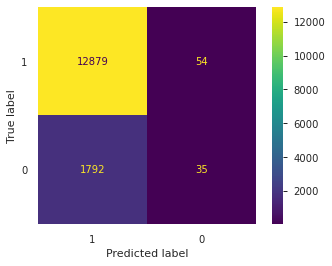

In [773]:
conf_m = confusion_matrix(y_valid, y_pred)
conf_m_displ = ConfusionMatrixDisplay(conf_m, display_labels=['1','0'])
conf_m_displ.plot()

#### Findings:
- So the Model is pretty good at predicting Positives, however quite bad at Negatives. This is also described by core metrics.
- ROC AUC score has improved through feature engineering and data transformation.
- Though data is not heavily imbalanced, to improve the metrics balancing might be useful.

#### We also checked hyperparameters but they worsened metrics so we'll leave it as a point for future improvements:

In [779]:
iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_

best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    
preds = model.predict(X_valid)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.34191617        nan
 0.34189784        nan 0.04797908 0.04698188        nan 0.04456433
 0.04225652 0.04797908 0.04698188        nan 0.04455838 0.04186747
 0.34191852 0.34054764 0.34181948 0.33727754 0.33683634 0.34191852
 0.34054764 0.34181948 0.33730417 0.33680033 0.04799806 0.04662193
 0.04456433 0.04186048 0.04799806 0.04662193 0.04475817 0.04145945
 0.34212897 0.33999948 0.33740241 0.33686327 0.34212897 0.33999948
 0.33729496 0.33690884]
  category=UserWarning


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: None
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6716
Precision: 0.2276
Recall: 0.6907
F1: 0.3424


# 19. Submission

In [774]:
train_data = data.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = data.query('Train == 0').drop(['Train', 'client_id'], axis=1)

In [775]:
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [776]:
# check
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 55), (73799, 55), (73799, 54), (73799,), (36349, 54))

In [777]:
logreg = LogisticRegression(random_state=RANDOM_SEED,max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [778]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]


submit = pd.DataFrame(df_test.client_id)
submit['default'] = y_pred_prob
submit.to_csv('submission.csv', index=False)